In [1]:
import os
import shutil
import random
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as plk
from glob import glob
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
from torch import optim
from torch import autograd
from torch.optim.lr_scheduler import ReduceLROnPlateau

- 寻找合适的片段

In [ ]:
label_dir = '/home/sharing/disk2/multimodal-sentiment-dataset/MSA-ZH/label/sentiment'
df_t = pd.read_csv(os.path.join(label_dir, 'label_T.csv'))
df_a = pd.read_csv(os.path.join(label_dir, 'label_A.csv'))
df_v = pd.read_csv(os.path.join(label_dir, 'label_V.csv'))
df_m = pd.read_csv(os.path.join(label_dir, 'label_M.csv'))

In [ ]:
pos_v, neg_v = 0.6, -0.6
t_pos = df_t[df_t['label'] >= pos_v].index.to_list()
t_neg = df_t[df_t['label'] <= neg_v].index.to_list()
a_pos = df_a[df_a['label'] >= pos_v].index.to_list()
a_neg = df_a[df_a['label'] <= neg_v].index.to_list()
v_pos = df_v[df_v['label'] >= pos_v].index.to_list()
v_neg = df_v[df_v['label'] <= neg_v].index.to_list()
m_pos = df_m[df_m['label'] >= pos_v].index.to_list()
m_neg = df_m[df_m['label'] <= neg_v].index.to_list()

In [ ]:
def listUnion(a, b):
    c = [v for v in a if v in b]
    return c

In [ ]:
index = 2117
print(df_t.iloc[index][['video_id', 'clip_id']])
print(df_t.iloc[index]['label'], df_a.iloc[index]['label'], df_v.iloc[index]['label'], df_m.iloc[index]['label'])

- 绘制音频波形图

/home/iyuge2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


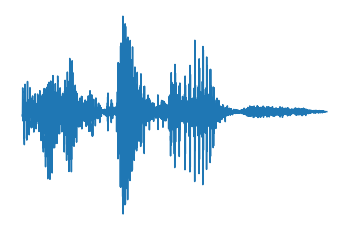

In [26]:
import wave
import pylab as pl
import numpy as np
# 打开WAV文档
f = wave.open(r"/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CMU_MOSI/Raw/Audio/WAV_16000/Segmented/8OtFthrtaJM_21.wav", "rb")
# 读取格式信息
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
# 读取波形数据
str_data = f.readframes(nframes)
f.close()
#将波形数据转换为数组
wave_data = np.fromstring(str_data, dtype=np.short)
wave_data.shape = -1, 2
wave_data = wave_data.T
time = np.arange(0, nframes) * (1.0 / framerate)
# 绘制波形
# pl.subplot(211) 
pl.plot(time, wave_data[0])
pl.axis('off')
# pl.subplot(212) 
# pl.plot(time, wave_data[1], c="g")
# pl.xlabel("time (seconds)")
pl.savefig('./wave.pdf', dpi=600, format='pdf')
pl.show()

In [ ]:
a = wave_data[0]
a = a.reshape(-1, 1)

In [ ]:
a = np.mean(a, axis=-1)

In [ ]:
# 绘制波形
# pl.subplot(211) 
pl.plot([i for i in range(len(a))], a)
pl.axis('off')
# pl.subplot(212) 
# pl.plot(time, wave_data[1], c="g")
# pl.xlabel("time (seconds)")
pl.savefig('./wave.svg', dpi=600, format='pdf')
pl.show()

In [ ]:
seeds = [1,12,123,1234,12345]
data_dir = '/home/iyuge2/Project/MSA-ZH/results/msazh'
models = ['lf_dnn', 'lmf', 'mfn', 'mlf_dnn', 'mult', 'tfn']
criterions = ['MAE', 'Corr', 'Mult_acc_2', 'Mult_acc_3', 'F1_score']

In [ ]:
results = {}
for model in models:
    model_res = {}
    for seed in seeds:
        path = os.path.join(data_dir, str(seed), model+'-msazh-M.csv')
        df = pd.read_csv(path, index_col=0)
        for index in df.index:
            if seed == seeds[0]:
                model_res[index] = [df.loc[index, 'M']]
            else:
                model_res[index].append(df.loc[index, 'M'])
    results[model] = model_res

In [ ]:
for modality in ['M', 'T', 'A', 'V']:
    model_res = {}
    for seed in seeds:
        path = os.path.join(data_dir, str(seed), 'mlf_dnn-msazh-MTAV.csv')
        df = pd.read_csv(path, index_col=0)
        for index in df.index:
            if seed == seeds[0]:
                model_res[index] = [df.loc[index, modality]]
            else:
                model_res[index].append(df.loc[index, modality])
    results['mlf_dnn'+'-'+modality] = model_res

In [ ]:
df = pd.DataFrame(columns=criterions)
for model in results.keys():
    cols = []
    for criterion in criterions:
        values = results[model][criterion]
        mean, std = round(np.mean(values)*100,2), round(np.std(values)*100,2)
        cols.append(str(mean)+'/'+str(std))
    df.loc[model] = cols

In [ ]:
df.to_csv(os.path.join(data_dir, 'stat.csv'))

In [ ]:
label_dir = '/home/sharing/disk2/multimodal-sentiment-dataset/MSA-ZH/label'
label_name = ['多模态', '视频', '文本', '音频']
labelers = ['孟繁阳', '朱益林', '马奕潇', '余文梦']

- 去除video_id与clip_id重复的行

In [ ]:
for lname in label_name:
    for i, labeler in enumerate(labelers):
        cur_path = os.path.join(label_dir, labeler, lname+'.xlsx')
        df_src = pd.read_excel(cur_path)
        df_src = df_src.drop_duplicates(subset=['video_id', 'clip_id'], keep='first', inplace=False)
        df_src.to_csv(cur_path.replace('.xlsx', '.csv'), index=None)

- 依据标准表筛出无效片段

In [ ]:
label_standard = pd.read_csv(os.path.join(label_dir, '余文梦', '多模态.csv'))

In [ ]:
drop_index = label_standard[label_standard['label'] == 2].index
for lname in label_name:
    for i, labeler in enumerate(labelers):
        cur_path = os.path.join(label_dir, labeler, lname+'.csv')
        df_src = pd.read_csv(cur_path)
        try:
            df_dst = df_src.drop(drop_index)
            df_dst.to_csv(cur_path, index=None)
        except:
            print(cur_path)

In [ ]:
label_standard = pd.read_csv(os.path.join(label_dir, '余文梦', '多模态.csv'))
video_dir = '/home/sharing/disk2/multimodal-sentiment-dataset/MSA-ZH/raw/v1'

In [ ]:
for path in video_pathes:
    clip_id = path.split('/')[-1].split('.')[0]
    new_path = path.replace(clip_id+'.mp4', '%04d.mp4' % int(clip_id))
    os.rename(path, new_path)

In [ ]:
for i in range(len(label_standard)):
    video_id, clip_id = label_standard.loc[i]['video_id'], label_standard.loc[i]['clip_id']
    src_path = os.path.join(video_dir, video_id, '%04d.mp4' %(clip_id))
    dst_path = src_path.replace('v-filtered', 'v1')
    if not os.path.exists(os.path.dirname(dst_path)):
        os.makedirs(os.path.dirname(dst_path))
    shutil.move(src_path, dst_path)

- 生成各个模态的标注结果

In [ ]:
column_names = ['video_id', 'clip_id'] + ['label_%d' %(i+1) for i in range(len(labelers))] + ['label']
for lname in label_name:
    if lname == '文本':
        column_names.append('text')
    df_dst = pd.DataFrame(columns=column_names)
    labels = []
    for i, labeler in enumerate(labelers):
        df_src = pd.read_csv(os.path.join(label_dir, labeler, lname+'.csv'))
        if i == 0:
            df_dst[['video_id', 'clip_id']] = df_src[['video_id', 'clip_id']]
            if lname == '文本':
                df_dst['text'] = df_src['text']
        df_dst['label_%d' %(i+1)] = df_src['label']
        labels.append(np.array(df_src['label']))
    df_dst['label'] = np.mean(np.array(labels), axis=0)
    df_dst.to_csv(os.path.join(label_dir, lname+'.csv'), index=None)

- 绘制标注结果统计图

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman',size='13')

In [ ]:
label_counts = []
label_dir = '/home/sharing/disk2/multimodal-sentiment-dataset/MSA-ZH/label/sentiment'
annotations = ['Negative','Weakly Negative','Neutral','Weakly Positive', 'Positive']
for lname in ['label_M', 'label_T', 'label_A', 'label_V']:
    df = pd.read_csv(os.path.join(label_dir, lname+'.csv'))
    counts = df['annotations'].value_counts()
    label_counts.append(list(counts[annotations]))

In [ ]:
label_counts

In [ ]:
x =np.arange(len(label_counts[0]))
bar_width = 0.2
fc_M = [1/255,77/255,103/255]
fc_T = [96/255,143/255,159/255]
fc_A = [251/255,178/255,23/255]
fc_V = [237/255,222/255,139/255]
plt.bar(x, label_counts[0], width=bar_width, label='M',fc = fc_M)
plt.bar(x+bar_width, label_counts[1], width=bar_width, label='T',fc = fc_T)
plt.bar(x+bar_width*2, label_counts[2], width=bar_width, label='A',fc = fc_A)
plt.bar(x+bar_width*3, label_counts[3], width=bar_width, label='V',fc = fc_V)

plt.legend() # 设置图例
plt.xticks(x+bar_width/2,annotations, rotation=15)#显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置
plt.savefig('./asserts/dataset-bar.pdf', dpi=600)
plt.show()

- 计算各模态之间的标签差异

In [ ]:
ys = []
for lname in ['label_M', 'label_T', 'label_A', 'label_V']:
    df = pd.read_csv(os.path.join(label_dir, lname+'.csv'))
    ys.append(np.array(df['label']))
ys = np.array(ys)
# diff = 1- np.corrcoef(ys)[:4, :4]
diff = np.zeros([4,4])
for i in range(4):
    for j in range(4):
        diff[i][j] = ((ys[i] - ys[j]) ** 2).mean()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title=None,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    YlOrBr
    """
    fig, ax = plt.subplots()
    # We want to show all ticks...
    ax.set(xticks=np.arange(4),
           yticks=np.arange(4),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
#            title=title)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0,
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(diff, classes=['M', 'T', 'A', 'V'],
                      title='')
plt.savefig('/home/iyuge2/Project/MSA-ZH/asserts/Annotation-diff.pdf', dpi=600, pad_inches=10)
plt.show()

- 生成结果分析

In [ ]:
method_names = ['EF_LSTM', 'LF_DNN', 'LMF', 'MFN', 'MULT', 'TFN']
df = pd.DataFrame(columns=['' for i in range(6)], index=method_names)
working_dir = '/home/iyuge2/Project/MSA-ZH/results/msazh'
methods = sorted(glob(os.path.join(working_dir, '*.csv')))

In [ ]:
for i, cur_method in enumerate(methods):
    df_src = pd.read_csv(cur_method, index_col=0)
    if cur_method.split('/')[-1] == 'stat.csv':
        continue
    if i == 0:
        df.columns = list(df_src.index)
    method_name = str.upper(cur_method.split('/')[-1].split('-')[0])
    evals = []
    for i in range(len(df_src)):
        evals.append(df_src.iloc[i][-1])
    df.loc[method_name] = evals

In [ ]:
df.to_csv(os.path.join(working_dir, 'stat.csv'))

#### 数据特征提取

- text(Bert)

In [ ]:
import torch
from transformers import *

In [ ]:
tokenizer_class = BertTokenizer
model_class = BertModel

In [ ]:
# directory is fine
pretrained_weights = '/home/sharing/disk3/pretrained_embedding/Chinese/bert/pytorch'

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [ ]:
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# add_special_tokens will add start and end token
input_ids = torch.tensor([tokenizer.encode("我有一个苹果", add_special_tokens=True)])

In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples

In [ ]:
last_hidden_states.size()

In [ ]:
data = np.load('/home/sharing/disk2/multimodal-sentiment-dataset/MSA-ZH/Processed/features/data.npz')

In [ ]:
data['feature_T'].shape

- mosi

In [ ]:
df = pd.read_csv('/home/sharing/disk2/multimodal-sentiment-dataset/MOSI/labels/OpinionLevelSentiment.csv', header=None)

In [ ]:
a = pickle.load(open('/home/sharing/disk2/multimodal-sentiment-dataset/MOSI/Processed/seq_length_50/mosi_data.pkl', 'rb'))

In [ ]:
a.keys()

In [ ]:
a['train'].keys()

In [ ]:
tv = a['train']['vision']
tt = a['train']['text']
ta = a['train']['audio']
tid = a['train']['id']
tlabel = a['train']['labels']

In [ ]:
type(tv)

In [ ]:
tid.shape

In [ ]:
input_dir = '/home/sharing/disk3/dataset/multimodal/msa-zh/raw'

In [ ]:
os.path.dirname(input_dir)

- 从视频中提取帧

In [ ]:
input_dir = '/home/sharing/disk3/dataset/multimodal/msa-zh/result/raw'
output_dir = '/home/sharing/disk3/dataset/multimodal/msa-zh/result/Processed/video/Frame'
video_pathes = sorted(glob(os.path.join(input_dir, '*/*.mp4')))

In [ ]:
video_pathes[0]

In [ ]:
video_id, clip_id = video_pathes[0].split('/')[-2:]

In [ ]:
for video_path in tqdm(video_pathes):
    video_id, clip_id = video_path.split('/')[-2:]
    clip_id = clip_id.split('.')[0]
    cur_output_dir = os.path.join(output_dir, video_id, clip_id)
    if not os.path.exists(cur_output_dir):
        os.makedirs(cur_output_dir)
    cmd = "ffmpeg -i " + video_path + " -r 30 " + cur_output_dir + "/%04d.png"
    os.system(cmd)

In [ ]:
video_output_dir = os.path.join(output_dir, input_dir.split('/')[-1])
if not os.path.exists(video_output_dir):
    os.mkdir(video_output_dir)
for cur_video in videos:
    output_path = os.path.join(video_output_dir, os.path.basename(cur_video).split('_')[0])
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    cmd = "ffmpeg -i " + cur_video + " -r 30 " + output_path + "/%04d.png"
    os.system(cmd)

- 统计帧数量

In [ ]:
xs, ys = [], []
videos = sorted(glob(os.path.join(output_dir, 'video_*')))
for cur_video in videos:
    video_clips = sorted(os.listdir(cur_video))
    for cur_clip in video_clips:
        xs.append(len(ys))
        ys.append(len(glob(os.path.join(cur_video, cur_clip, '*.png'))))

In [ ]:
plt.plot(xs, ys)

- 从帧中提取对齐后的人脸

In [ ]:
133 / 60

In [ ]:
input_dir = './Frames'
output_dir = './AlignedFaces'
videos = sorted(glob(os.path.join(input_dir, 'video_*')))
mtcnn = MTCNN(image_size=224, margin=0)
sx, sy = [], []

In [ ]:
for cur_video in videos:
    video_clips = sorted(os.listdir(cur_video))
#     print(video_clips)
    for cur_clip in tqdm(video_clips):
        imgs = sorted(glob(os.path.join(cur_video, cur_clip, '*.png')))
        for cur_img in imgs:
            output_path = cur_img.replace('Frames', 'AlignedFaces')
            cur_output_dir = os.path.dirname(output_path)
            if not os.path.exists(cur_output_dir):
                os.makedirs(cur_output_dir)
            img = Image.open(cur_img)
            mtcnn(img, save_path=output_path)
        sx.append(len(sy))
        sy.append(len(glob(os.path.join(cur_output_dir, '*.png'))))

In [ ]:
plt.plot(sx, sy)

### MOSI && MOSEI

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as plk

In [16]:
def formatData(src_path, dst_dir, save_name):
    # format raw features as our format (for MOSI, MOSEI)
    with open(src_path, 'rb') as df:
        data = plk.load(df)
    train_len = len(data['train']['labels'])
    valid_len = len(data['valid']['labels'])
    test_len = len(data['test']['labels'])
    print(train_len, valid_len, test_len)
    
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    
    # format data
    print('format data')
    new_data = {}
    for item in data['train'].keys():
        cur = []
        for mode in ['train', 'valid', 'test']:
            cur.append(data[mode][item])
        new_data[item] = np.concatenate(cur, axis = 0)
    
    # add the "protocol" param to support file larger than 4 GBs.
    with open(os.path.join(dst_dir, save_name + '_data.pkl'), 'wb') as df:
        plk.dump(new_data, df, protocol = 4)
    
    # get train/valid/test index
    print('get train/valid/test index')
    new_index = {}
    new_index['train'] = np.array([i for i in range(train_len)])
    new_index['valid'] = np.array([i for i in range(train_len, train_len+valid_len)])
    new_index['test'] = np.array([i for i in range(train_len+valid_len, train_len+valid_len+test_len)])
    
    # save index
    indexPath = os.path.join(dst_dir, save_name + '_index.pkl')
    if not os.path.exists(indexPath):
        with open(indexPath, 'wb') as df:
            plk.dump(new_index, df, protocol = 4)

In [17]:
src_path = '/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CMU-MOSEI/Processed/mosei_senti_data.pkl'
dst_dir = '/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CMU-MOSEI/Processed/Format/Our'
save_name = 'mosei_aligned'
formatData(src_path, dst_dir, save_name)

16265 1869 4643
format data
get train/valid/test index


- the first 300 is the word vectors, the next 5 are acoustic and the rest is visual.

In [2]:
import h5py

In [103]:
root_dir = '/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CMU_MOSI'
X_train = h5py.File(os.path.join(root_dir, 'Processed/seq_length_20/X_train.h5'), 'r')
X_valid = h5py.File(os.path.join(root_dir, 'Processed/seq_length_20/X_valid.h5'), 'r')
X_test = h5py.File(os.path.join(root_dir, 'Processed/seq_length_20/X_test.h5'), 'r')
y_train = h5py.File(os.path.join(root_dir, 'Processed/seq_length_20/y_train.h5'), 'r')
y_valid = h5py.File(os.path.join(root_dir, 'Processed/seq_length_20/y_valid.h5'), 'r')
y_test = h5py.File(os.path.join(root_dir, 'Processed/seq_length_20/y_test.h5'), 'r')

In [106]:
X_train = np.array(X_train['data'])
X_valid = np.array(X_valid['data'])
X_test = np.array(X_test['data'])
y_train = np.array(y_train['data'])
y_valid = np.array(y_valid['data'])
y_test = np.array(y_test['data'])

In [ ]:
new_data = {}
new_data['text'] = np.concatenate([X_train[:,:,:300], X_valid[:,:,:300], X_test[:,:,:300]], axis=0)
new_data['audio'] = np.concatenate([X_train[:,:,300:305], X_valid[:,:,300:305], X_test[:,:,300:305]], axis=0)
new_data['vision'] = np.concatenate([X_train[:,:,305:], X_valid[:,:,305:], X_test[:,:,305:]], axis=0)

In [ ]:
new_data['labels'] = np.concatenate([y_train, y_valid, y_test], axis=0)

### CH-SIMS

In [32]:
from transformers import *

In [33]:
data = np.load('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CH-SIMS/Processed/features/data.npz')
data = dict(data)
data.keys()

dict_keys(['feature_T', 'feature_A', 'feature_V', 'label_T', 'label_A', 'label_V', 'label_M'])

In [34]:
label_path = '/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CH-SIMS/metadata/sentiment'
df_label_T = pd.read_csv(os.path.join(label_path, 'label_T.csv'))
df_label_A = pd.read_csv(os.path.join(label_path, 'label_A.csv'))
df_label_V = pd.read_csv(os.path.join(label_path, 'label_V.csv'))
df_label_M = pd.read_csv(os.path.join(label_path, 'label_M.csv'))

In [35]:
tokenizer_class = BertTokenizer
model_class = BertModel
# directory is fine
# pretrained_weights = '/home/sharing/disk3/pretrained_embedding/Chinese/bert/pytorch'
pretrained_weights = '/home/sharing/disk3/pretrained_embedding/bert/chinese_L-12_H-768_A-12'
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [108]:
text_len = data['feature_T'].shape[1]
ids, rawText = [], []
Input_ids = []
Input_mask, segment_ids = [], []
for i in tqdm(range(len(df_label_T))):
    video_id, clip_id = df_label_T.loc[i, ['video_id', 'clip_id']]
    clip_id = '%04d' % clip_id
    
    ids.append(video_id + '_' + clip_id)
    text = df_label_T.loc[i, 'text']
    rawText.append(text)
    
    if len(text) > text_len - 2:
        text = text[:text_len-2]
    
    cur_input = torch.tensor(tokenizer.encode(text, add_special_tokens=True))
    cur_input = list(cur_input.squeeze().numpy())
    Input_ids.append(cur_input + [0]*(text_len - len(cur_input)))
    Input_mask.append([1] * (len(cur_input)) + [0] * (text_len - len(cur_input)))
    segment_ids.append([0]*text_len)

100%|██████████| 2281/2281 [00:01<00:00, 1219.24it/s]


In [111]:
Input_ids = np.array(Input_ids)
Input_mask = np.array(Input_mask)
segment_ids = np.array(segment_ids)

In [112]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/CH-SIMS/metadata/index.pkl', 'rb') as tmp:
    indexes = plk.load(tmp)

In [113]:
train_index = indexes['train']
valid_index = indexes['valid']
test_index = indexes['test']

In [116]:
def splitData(index):
    results = {}
    results['feature_T'] = data['feature_T'][index]
    results['feature_A'] = data['feature_A'][index]
    results['feature_V'] = data['feature_V'][index]
    
    results['label_T'] = data['label_T'][index]
    results['label_A'] = data['label_A'][index]
    results['label_V'] = data['label_V'][index]
    results['label_M'] = data['label_M'][index]
    
    results['ids'] = [ids[i] for i in index]
    results['raw_text'] = [rawText[i] for i in index]
    
    tmp_in_ids = np.expand_dims(Input_ids[index], 1)
    tmp_in_mask = np.expand_dims(Input_mask[index], 1)
    tmp_seg_ids = np.expand_dims(segment_ids[index], 1)
    
    results['text_bert'] = np.concatenate((tmp_in_ids, tmp_in_mask, tmp_seg_ids), axis=1) 
    
    return results

In [117]:
save = {}
save['train'] = splitData(train_index)
save['valid'] = splitData(valid_index)
save['test'] = splitData(test_index)

In [119]:
save['train']['text_bert'].shape

(1368, 3, 39)

In [21]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/sims/unaligned_37.pkl', 'wb') as df:
    plk.dump(save, df, protocol = 4)

In [119]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/mosi/feature/aligned_50.pkl', 'rb') as ff:
    alignedData = plk.load(ff)
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/mosi/raw/aligned_50.pkl', 'rb') as ff:
    rawAlignedData = plk.load(ff)

In [121]:
alignedData['train'].keys()

dict_keys(['vision', 'labels', 'text', 'audio', 'id'])

In [122]:
rawAlignedData['train'].keys()

dict_keys(['raw_text', 'audio', 'vision', 'labels', 'id', 'text'])

In [123]:
for mode in ['train', 'valid', 'test']:
    rawAlignedData[mode]['text_bert'] = rawAlignedData[mode]['text']
    rawAlignedData[mode]['text'] = alignedData[mode]['text']

In [124]:
rawAlignedData['valid'].keys()

dict_keys(['raw_text', 'audio', 'vision', 'labels', 'id', 'text', 'text_bert'])

In [125]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/mosi/aligned_50.pkl', 'wb') as df:
    plk.dump(rawAlignedData, df, protocol = 4)

In [131]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/sims/unaligned_39.pkl', 'rb') as lf:
    data = plk.load(lf)

In [140]:
data['train'].keys()

dict_keys(['feature_T', 'feature_A', 'feature_V', 'label_T', 'label_A', 'label_V', 'label_M', 'ids', 'raw_text', 'text_bert'])

In [141]:
data['valid'].keys()

dict_keys(['feature_T', 'feature_A', 'feature_V', 'label_T', 'label_A', 'label_V', 'label_M', 'ids', 'raw_text', 'text_bert'])

In [142]:
data['test'].keys()

dict_keys(['feature_T', 'feature_A', 'feature_V', 'label_T', 'label_A', 'label_V', 'label_M', 'ids', 'raw_text', 'text_bert'])

In [143]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/sims/unaligned_39.pkl', 'wb') as df:
    plk.dump(data, df, protocol = 4)

#### 补充序列长度

In [22]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/mosei/unaligned_50.pkl', 'rb') as lf:
    data = plk.load(lf)

In [2]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/mosi/unaligned_50.pkl', 'rb') as lf:
    data = plk.load(lf)

In [5]:
data['train'].keys()

dict_keys(['raw_text', 'audio', 'vision', 'labels', 'id', 'text', 'text_bert', 'audio_lengths', 'vision_lengths'])

In [6]:
data['train']['audio'].shape

(1284, 375, 5)

In [7]:
def get_lengths(mode, feature_name):
    fd = data[mode][feature_name]
    max_len = fd.shape[1]
    
    c_sum = np.sum(fd, axis=-1)
    new_features = []
    lengths = []
    for i in tqdm(range(fd.shape[0])):
        null = True
        zeros = np.zeros([fd.shape[1], fd.shape[2]])
        for j in range(max_len):
            if c_sum[i][j] != 0:
                lengths.append(max_len - j)
                tmp_feat = np.concatenate([fd[i,j:], zeros[:j]], axis = 0)
                null = False
                break
        if null:
            lengths.append(1)
            new_features.append(fd[i])
        else:
            new_features.append(tmp_feat)
    return lengths, np.array(new_features)

In [8]:
mode = 'test'
ll, _ = get_lengths(mode, 'audio')

100%|██████████| 686/686 [00:00<00:00, 102060.60it/s]


In [8]:
mode = 'test'
data[mode]['audio_lengths'], data[mode]['audio'] = get_lengths(mode, 'audio')
data[mode]['vision_lengths'], data[mode]['vision'] = get_lengths(mode, 'vision')

100%|██████████| 4659/4659 [00:00<00:00, 23270.28it/s]


In [9]:
with open('/home/sharing/disk3/dataset/multimodal-sentiment-dataset/ALL/mosei/unaligned_50_new.pkl', 'wb') as df:
    plk.dump(data, df, protocol = 4)

In [192]:
def label_counts(labels):
#     ms = [-1.01, -0.7, -0.1, 0.1, 0.7, 1.01] # splits
#     ms = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
    ms = [-3.5, 0.0, 3.5]
    counts = []
    for i in range(len(ms)-1):
        c_num = (labels >= ms[i]) & (labels < ms[i+1])
        counts.append(c_num.sum())
    return counts

def draw(data, epochs=1):
    c_data = data[epochs]
    label_counts_M = label_counts(c_data['fusion'])
    label_counts_T = label_counts(c_data['text'])
    label_counts_A = label_counts(c_data['audio'])
    label_counts_V = label_counts(c_data['vision'])
    
    x =np.arange(len(label_counts_M))
    bar_width = 0.15
    fc_M = [1/255,77/255,103/255]
    fc_T = [96/255,143/255,159/255]
    fc_A = [251/255,178/255,23/255]
    fc_V = [237/255,222/255,139/255]
    
    plt.figure(figsize=(4, 4)) #  设置图大小
    
    plt.bar(x, label_counts_M, width=bar_width, label='M',fc = fc_M)
    plt.bar(x+bar_width, label_counts_T, width=bar_width, label='T',fc = fc_T)
    plt.bar(x+bar_width*2, label_counts_A, width=bar_width, label='A',fc = fc_A)
    plt.bar(x+bar_width*3, label_counts_V, width=bar_width, label='V',fc = fc_V)
    
#     annotations = ['Negative','Weakly Negative','Neutral','Weakly Positive', 'Positive']
    annotations = ['Negative', 'Positive']

#     plt.legend(loc='best', fontsize=8) # 设置图例
    plt.xticks(x+1.5*bar_width,annotations, rotation=0)#显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置
    plt.savefig('dataset-bar.pdf', dpi=300)
    plt.show()

In [6]:
with open('/home/iyuge2/Project/MSA-AAAI2021/results/FinalSave/lsmmsa-mosi.pkl', 'rb') as df:
    data = plk.load(df)

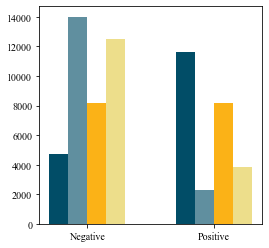

In [195]:
plt.rcParams['font.sans-serif'] = ['Times New Roman']
draw(data, epochs=15)

In [9]:
dd = data[30]

In [24]:
s_id = 0
select = 0
for s_id in range(len(dd['fusion'])):
    if dd['fusion'][s_id] > 0 and dd['text'][s_id] < 0:
        print("########################")
        print(dd['fusion'][s_id])
        print(dd['text'][s_id])
        print(dd['audio'][s_id])
        print(dd['vision'][s_id])
        print(dd['ids'][s_id])
        print("########################")
        select += 1
    if select > 50:
        break

########################
0.8
-0.61236525
0.021002334
0.38798374
2WGyTLYerpo_43
########################
########################
0.2
-0.18476462
0.18690544
0.014432773
VbQk4H8hgr0_40
########################
########################
0.6
-0.71565354
-0.3044953
0.8664003
BI97DNYfe5I_28
########################
########################
0.8
-0.26670468
-0.9691915
-0.20726396
OQvJTdtJ2H4_6
########################
########################
0.8
-0.68449354
0.7882346
0.11034965
Njd1F0vZSm4_4
########################
########################
0.4
-0.66205025
0.16210768
0.38561234
TvyZBvOMOTc_8
########################
########################
1.25
-0.8509356
-0.99592495
-0.46805984
Vj1wYRQjB-o_6
########################
########################
1.4
-0.66339445
-1.1928812
-0.7927389
G-xst2euQUc_20
########################
########################
0.2
-0.9382811
0.81306154
0.6729532
PZ-lDQFboO8_10
########################
########################
0.6
-0.57875186
1.1517175
0.4747908
Af8D0E4ZXaw_1
#